In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#sns.set(style="ticks")
from scipy import signal
from scipy.optimize import leastsq
from scipy.fft import rfft, rfftfreq
from scipy import signal

from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
import math
import csv
from datetime import datetime
from dateutil import parser
from datetime import datetime, timedelta

In [19]:
#accel
accel= pd.read_csv('/Users/juliapersche/Desktop/Most_Recent/5_accel.csv')

#convert timestamps 
new_timestamps_accel = []

for idx, row in accel.iterrows():
     newtime = (row['ts']).astype(str)
     newtime_2 = newtime[:-8]
     new_timestamps_accel.append(newtime_2)
    
accel['Timestamp'] = new_timestamps_accel
accel['Timestamp'] = accel['Timestamp'].apply(int)

#computing energy (of accel)
accel['x_norm'] = (accel['x'] - accel['x'].mean()) / (accel['x'].max() - accel['x'].min())
accel['y_norm'] = (accel['y'] - accel['y'].mean()) / (accel['y'].max() - accel['y'].min())
accel['z_norm'] = (accel['z'] - accel['z'].mean()) / (accel['z'].max() - accel['z'].min())

accel['energy'] = accel['x_norm']**2 + accel['y_norm']**2 + accel['z_norm']**2

accel.drop('ts', axis=1, inplace=True)
accel.head()


,x,y,z,Timestamp,x_norm,y_norm,z_norm,energy
0,-9.67,-0.04,1.91,1679065856,0.017443,0.000457,0.162563,0.026731
1,-9.65,-0.03,1.90,1679065856,0.022251,0.001278,0.161406,0.026549
2,-9.65,-0.05,1.94,1679065856,0.022251,-0.000364,0.166036,0.028063
3,-9.66,-0.02,1.90,1679065856,0.019847,0.002099,0.161406,0.026450
4,-9.66,-0.04,1.91,1679065856,0.019847,0.000457,0.162563,0.026821


262


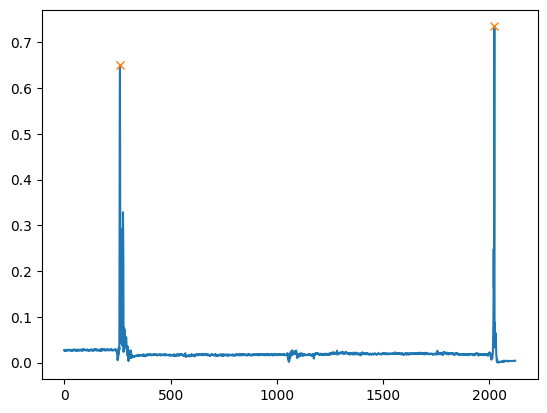

In [33]:
#Accel peak height is relative and will probably need to be adjusted between files
energy_peaks, _ = find_peaks(accel['energy'], height=.4)
plt.plot(accel['energy'])
plt.plot(energy_peaks, accel['energy'][energy_peaks], "x")


In [47]:
#Cutoff at 1st max energy point:
cutoff = energy_peaks[0]
start_timestamp = accel['Timestamp'].iloc[cutoff]
print(start_timestamp)
accel = accel[accel['Timestamp'] >= start_timestamp]
accel.head()

1679065908


,x,y,z,Timestamp,x_norm,y_norm,z_norm,energy
515,-9.72,-0.03,1.61,1679065908,0.005424,0.001278,0.127841,0.016374
516,-9.71,-0.11,1.60,1679065908,0.007828,-0.005290,0.126684,0.016138
517,-9.70,-0.08,1.63,1679065908,0.010232,-0.002827,0.130156,0.017053
518,-9.73,0.00,1.68,1679065908,0.003020,0.003741,0.135943,0.018504
519,-9.71,-0.06,1.61,1679065908,0.007828,-0.001185,0.127841,0.016406


In [49]:
#RR File 
RR= pd.read_csv('/Users/juliapersche/Desktop/Most_Recent/2_RR.csv')

RR['Timestamp'] = RR['Data Set 1:Time(s)']
RR['Force'] = RR['Data Set 1:Force(N)']
RR['Respiration Rate'] = RR['Data Set 1:Respiration Rate(bpm)']


RR.drop('Data Set 1:Time(s)', axis=1, inplace=True)
RR.drop('Data Set 1:Force(N)', axis=1, inplace=True)
RR.drop('Data Set 1:Respiration Rate(bpm)', axis=1, inplace=True)

RR.head()

,Timestamp,Force,Respiration Rate
0,0.0,3.058189,20.316027
1,0.1,2.649391,NaN
2,0.2,2.197159,NaN
3,0.3,2.092400,NaN
4,0.4,1.995316,NaN


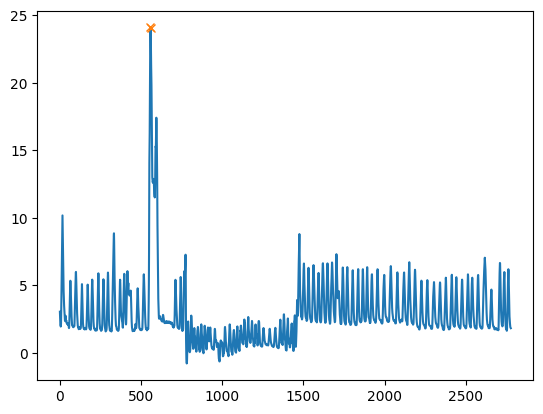

In [52]:
#RR Peak height is relative and will probably need to be adjusted between files
#Accel peak height is relative and will probably need to be adjusted between files
RR_peaks, _ = find_peaks(RR['Force'], height=20)
plt.plot(RR['Force'])
plt.plot(RR_peaks, RR['Force'][RR_peaks], "x")

In [53]:
#Cutoff at RR:
cutoff_RR = RR_peaks[0]
start_timestampRR = RR['Timestamp'].iloc[cutoff_RR]
print(start_timestampRR)
RR = RR[RR['Timestamp'] >= start_timestampRR]
RR.head()

55.7


,Timestamp,Force,Respiration Rate
557,55.7,24.096062,NaN
558,55.8,24.055183,NaN
559,55.9,24.078178,NaN
560,56.0,23.380661,NaN
561,56.1,22.121048,NaN


In [42]:
#ppg
ppg= pd.read_csv('/Users/juliapersche/Desktop/Most_Recent/5_ppg.csv')
new_timestamps_ppg = []

for idx, row in ppg.iterrows():
     newtime = (row['ts']).astype(str)
     newtime_2 = newtime[:-8]
     new_timestamps_ppg.append(newtime_2)
    
ppg['Timestamp'] = new_timestamps_ppg
ppg['Timestamp'] = ppg['Timestamp'].apply(int)
ppg.drop('ts', axis=1, inplace=True)

#Line up with accel cutoff
ppg = ppg[ppg['Timestamp'] >= start_timestamp]
ppg.head()

,red,ir,green,Timestamp
2592,122572.0,134621.0,11575.0,1679065882
2593,122720.0,134847.0,11587.0,1679065882
2594,122938.0,135125.0,11613.0,1679065882
2595,123090.0,135241.0,11610.0,1679065882
2596,123137.0,135319.0,11612.0,1679065882


In [50]:
PO= pd.read_csv('/Users/juliapersche/Desktop/Most_Recent/5_PO.csv')
EKG= pd.read_csv('/Users/juliapersche/Desktop/Most_Recent/5_EKG.csv')
EKG['Timestamp']  = (pd.to_datetime(EKG['time'])- pd.Timestamp('1970-01-01')).astype('timedelta64[s]').astype('int')

#Line up with accel cutoff
PO = PO[PO['Timestamp'] >= start_timestamp]
EKG = EKG[EKG['Timestamp'] >= start_timestamp]
        
PO.drop('Date', axis=1, inplace=True)
PO.drop('Time', axis=1, inplace=True)
PO.drop('Session', axis=1, inplace=True)
PO.drop('Index', axis=1, inplace=True)

EKG.drop('time', axis=1, inplace=True)
EKG.head()

,ecg,hr,rr,marker,Timestamp
9610,-0.298,NaN,NaN,NaN,1679065908
9611,-0.269,NaN,NaN,NaN,1679065908
9612,-0.296,NaN,NaN,NaN,1679065908
9613,-0.288,NaN,NaN,NaN,1679065908
9614,-0.225,NaN,NaN,NaN,1679065908
